**Table of contents**<a id='toc0_'></a>    
- 1. [Nankai overview      ](#toc1_)    
- 2. [Load datasets     ](#toc2_)    
  - 2.1. [Load JMA catalog     ](#toc2_1_)    
    - 2.1.1. [Zoom in Shikoku/Kii/Tokai     ](#toc2_1_1_)    
  - 2.2. [World tremor database    ](#toc2_2_)    
  - 2.3. [Shikoku LFEs   ](#toc2_3_)    
- 3. [Automatic cluster detection  ](#toc3_)    
  - 3.1. [Shikoku  ](#toc3_1_)    
    - 3.1.1. [Cluster detection  ](#toc3_1_1_)    
    - 3.1.2. [One zone look up  ](#toc3_1_2_)    
    - 3.1.3. [Across the region ](#toc3_1_3_)    
  - 3.2. [Kii  ](#toc3_2_)    
    - 3.2.1. [Cluster detection](#toc3_2_1_)    
    - 3.2.2. [One zone look up  ](#toc3_2_2_)    
    - 3.2.3. [Across the region ](#toc3_2_3_)    
  - 3.3. [Tokai  ](#toc3_3_)    
    - 3.3.1. [Cluster detection](#toc3_3_1_)    
    - 3.3.2. [One zone look up  ](#toc3_3_2_)    
    - 3.3.3. [Across the region ](#toc3_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Nankai overview       [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

from scipy.optimize import curve_fit

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect
from stats import cross_corr


# 2. <a id='toc2_'></a>Load datasets      [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Load JMA catalog      [&#128285;](#toc0_)

In [2]:
# # Load JMA catalog
# path = workdir + 'projects/data/Catalogs/JMA/jma_hypo_2000_2021.dat'

# # Read catalog
# cshift = 1  # use 1-indexing to better read the column using the guide at https://www.data.jma.go.jp/svd/eqev/data/bulletin/data/format/hypfmt_e.html

# record_type_id = []
# year = []
# month = []
# day = []
# hour = []
# minute = []
# second = []
# std_err_t = []
# lat_deg = []
# lat_min = []
# std_err_lat = []
# lon_deg = []
# lon_min = []
# std_err_lon = []
# depth = []
# std_err_depth = []
# mag1 = []
# mag1_type = []
# mag2 = []
# mag2_type = []
# trav_t_table = []
# hypo_loc_prec = []
# sub_info = []
# max_int = []
# dam_class = []
# tsun_class = []
# distr_nb = []
# reg_nb = []
# reg_name = []
# nb_st = []
# hyp_det_flag = []


# with open(path, 'r') as f:
#     lines = f.readlines()
#     for l in lines:
#         # Read the line
#         record_type_id.append(l[1 - cshift])
#         year.append(l[2 - cshift:6 - cshift])
#         month.append(l[6 - cshift:8 - cshift])
#         day.append(l[8 - cshift:10 - cshift])
#         hour.append(l[10 - cshift:12 - cshift])
#         minute.append(l[12 - cshift:14 - cshift])
#         second.append(l[14 - cshift:18 - cshift])
#         std_err_t.append(l[18 - cshift:22 - cshift])
#         lat_deg.append(l[22 - cshift:25 - cshift])
#         lat_min.append(l[25 - cshift:29 - cshift])
#         std_err_lat.append(l[29 - cshift:33 - cshift])
#         lon_deg.append(l[33 - cshift:37 - cshift])
#         lon_min.append(l[37 - cshift:41 - cshift])
#         std_err_lon.append(l[41 - cshift:45 - cshift])
#         depth.append(l[45 - cshift:50 - cshift])
#         std_err_depth.append(l[50 - cshift:53 - cshift])
#         mag1.append(l[53 - cshift:55 - cshift])
#         mag1_type.append(l[55 - cshift])
#         mag2.append(l[56 - cshift:58 - cshift])
#         mag2_type.append(l[58 - cshift])
#         trav_t_table.append(l[59 - cshift])
#         hypo_loc_prec.append(l[60 - cshift])
#         sub_info.append(l[61 - cshift])
#         max_int.append(l[62 - cshift])
#         dam_class.append(l[63 - cshift])
#         tsun_class.append(l[64 - cshift])
#         distr_nb.append(l[65 - cshift])
#         reg_nb.append(l[66 - cshift:69 - cshift])
#         reg_name.append(l[69 - cshift:93 - cshift])
#         nb_st.append(l[93 - cshift:96 - cshift])
#         hyp_det_flag.append(l[96 - cshift])

In [3]:
# # Process the columns
# # --> Time 
# year = np.array(year, dtype=int)
# month = np.array(month, dtype=int)
# day = np.array(day, dtype=int)
# hour = np.array(hour, dtype=int)
# minute = np.array(minute, dtype=int)
# second = np.array(second, dtype=float)/100
# std_err_t = np.array([float(err) if err != '    ' else 0. for err in std_err_t]) / 100

# date = [np.datetime64(f'{y:04d}-{m:02d}-{d:02d}T{h:02d}:{mi:02d}:{s:05.2f}') for y, m, d, h, mi, s in zip(year, month, day, hour, minute, second)]

# # --> Location
# lat_deg = np.array([float(l.replace(" ", "")) for l in lat_deg])
# lat_min = np.array(lat_min, dtype=float)/100
# std_err_lat = np.array([float(err) if err != '    ' else 0. for err in std_err_lat]) / 100 / 60

# lat = lat_deg + lat_min/60

# lon_deg = np.array([float(l.replace(" ", "")) for l in lon_deg])
# lon_min = np.array(lon_min, dtype=float)/100
# lon = lon_deg + lon_min/60
# std_err_lon = np.array([float(err) if err != '    ' else 0. for err in std_err_lon]) / 100 / 60

# depth = np.array([float(d.replace(" ", "0")) / 100 if d[-2] != '  ' else float(d) for d in depth])
# std_err_depth = np.array([float(err) if err != '   ' else 0. for err in std_err_depth]) / 100

# # --> Magnitude
# for ii, m in enumerate(mag1):
#     if m == '  ':
#         mag1[ii] = np.nan
#     elif m[0] == '-':
#         mag1[ii] = -float(m[1])/10
#     elif m[0] == 'A':
#         mag1[ii] = -1. - float(m[1])/10
#     elif m == 'B':
#         mag1[ii] = -2 - float(m[1])/10
#     elif m == 'C':
#         mag1[ii] = -3 - float(m[1])/10
#     else:
#         mag1[ii] = float(m) / 10
# mag1 = np.array(mag1)

# for ii, m in enumerate(mag2):
#     if m == '  ':
#         mag2[ii] = np.nan
#     elif m[0] == '-':
#         mag2[ii] = -float(m[1])/10
#     elif m[0] == 'A':
#         mag2[ii] = -1. - float(m[1])/10
#     elif m == 'B':
#         mag2[ii] = -2 - float(m[1])/10
#     elif m == 'C':
#         mag2[ii] = -3 - float(m[1])/10
#     else:
#         mag2[ii] = float(m) / 10
# mag2 = np.array(mag2)

# # --> Event types
# for ii, info in enumerate(sub_info):
#     if info == '1':
#         sub_info[ii] = 'eq'
#     elif info == '2':
#         sub_info[ii] = 'too few jma st'
#     elif info == '3':
#         sub_info[ii] = 'artificial event'
#     elif info == '4':
#         sub_info[ii] = 'eruption eq and others'
#     elif info == '5':
#         sub_info[ii] = 'lfe'
# sub_info = np.array(sub_info)

# # --> Location
# distr_nb = np.array([int(d) for d in distr_nb])
# reg_nb = np.array([int(r) if r != '   ' else 0 for r in reg_nb])
# nb_st = np.array([int(n) if n != '   ' else 0 for n in nb_st])

In [4]:
# # Make a dataframe out of the columns
# jma = pd.DataFrame({'date': date, 'lat': lat, 'lon': lon, 'depth': depth, 'mag': mag1, 'mag2': mag2, 'sub_info': sub_info, 'distr_nb': distr_nb, 'reg_nb': reg_nb, 'nb_st': nb_st})
# eq = jma[jma.sub_info == 'eq']
# lfe_jma = jma[jma.sub_info == 'lfe']

# # Save the catalogs
# eq.to_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv', index=False)
# lfe_jma.to_csv(workdir + 'projects/data/Catalogs/JMA/lfe_2000_2021.csv', index=False)
# jma.to_csv(workdir + 'projects/data/Catalogs/JMA/jma_2000_2021.csv', index=False)

# # Delete columns and lines 
# del date, lat, lat_deg, lat_min, lon, lon_deg, lon_min, depth, mag1, mag2, sub_info, distr_nb, reg_nb, nb_st, year, month, day, hour, minute, second, std_err_t, std_err_lat, std_err_lon, std_err_depth, mag1_type, mag2_type, trav_t_table, hypo_loc_prec, max_int, dam_class, tsun_class, reg_name, hyp_det_flag

In [5]:
# Directly load catalog from csv
eq = pd.read_csv(workdir + 'projects/data/Catalogs/JMA/eq_2000_2021.csv')

## 2.2. <a id='toc2_2_'></a>World tremor database     [&#128285;](#toc0_)

In [6]:
# Load data
path = workdir + 'projects/data/Catalogs/world_tremor_database/nankai_wtb_0413.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd = pd.read_csv(
    path,
    names=COLS,
)

wtd['date_str'] = wtd.date.values + ' ' + wtd.time.values
wtd['date'] = pd.to_datetime(wtd.date_str)
day0 = np.datetime64('2004-01-01')
wtd['day'] = (wtd.date - day0) / np.timedelta64(1, 'D')

wtd.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd.size, wtd.date.min().year, wtd.date.max().year))

905025 tremor detections, spanning 2004--2013


In [7]:
# Pick transect points
# fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.add_feature(cfeature.COASTLINE, zorder=10)
# ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

# ax.plot(wtd.lon, wtd.lat, 'o', color=to_rgba('C2', .2), markersize=1, transform=ccrs.PlateCarree(), label='Low-frequency earthquakes')

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# ax.legend(framealpha=1, loc='lower right', markerscale=5)

# ax.set_extent([131.3, 139.1, 31.25, 36.7])

# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lon, lat = event.xdata, event.ydata
#         picked_locations.append((lon, lat))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")
#         ax.plot([pl[0] for pl in picked_locations], [pl[1] for pl in picked_locations], 'x-', color='r', markersize=10, zorder=11, transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

In [8]:
# Save the picked locations
# plt.close('all')

shikoku_transect_line = {'W':{'lon': 131.8283, 'lat': 33.1195}, 'E':{'lon':134.2061, 'lat':34.1385}}
kii_transect_line = {'W':{'lon': 135.1496, 'lat': 33.6479}, 'E':{'lon':136.7599, 'lat':34.75499}}
tokai_transect_line = {'W':{'lon': 136.9864, 'lat': 34.9059}, 'E':{'lon':138.0054, 'lat':35.3462}}

In [9]:
# Project tremor and earthquakes, and separate them by region
# --> shikoku EQ
shikoku_eq_indicator = (eq.lon > shikoku_transect_line['W']['lon']) & (eq.lon < shikoku_transect_line['E']['lon'])
eq_shikoku = eq[shikoku_eq_indicator].copy()
t = transect(eq_shikoku.lon.values, eq_shikoku.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
eq_shikoku['xf'] = t[0]
eq_shikoku['yf'] = t[1]
eq_shikoku = eq_shikoku[abs(eq_shikoku.yf)< 50]

# --> shikoku LFE
shikoku_trm_indicator = (wtd.lon > shikoku_transect_line['W']['lon']) & (wtd.lon < shikoku_transect_line['E']['lon'])
trm_shikoku = wtd[shikoku_trm_indicator].copy()
t = transect(trm_shikoku.lon.values, trm_shikoku.lat.values, shikoku_transect_line['W']['lon'], shikoku_transect_line['W']['lat'], shikoku_transect_line['E']['lon'], shikoku_transect_line['E']['lat'])
trm_shikoku['xf'] = t[0]
trm_shikoku['yf'] = t[1]
trm_shikoku = trm_shikoku[abs(trm_shikoku.yf)< 50]

# --> kii EQ
kii_eq_indicator = (eq.lon > kii_transect_line['W']['lon']) & (eq.lon < kii_transect_line['E']['lon'])
eq_kii = eq[kii_eq_indicator].copy()
t = transect(eq_kii.lon.values, eq_kii.lat.values, kii_transect_line['W']['lon'], kii_transect_line['W']['lat'], kii_transect_line['E']['lon'], kii_transect_line['E']['lat'])
eq_kii['xf'] = t[0]
eq_kii['yf'] = t[1]
eq_kii = eq_kii[abs(eq_kii.yf)< 50]

# --> kii LFE
kii_trm_indicator = (wtd.lon > kii_transect_line['W']['lon']) & (wtd.lon < kii_transect_line['E']['lon'])
trm_kii = wtd[kii_trm_indicator].copy()
t = transect(trm_kii.lon.values, trm_kii.lat.values, kii_transect_line['W']['lon'], kii_transect_line['W']['lat'], kii_transect_line['E']['lon'], kii_transect_line['E']['lat'])
trm_kii['xf'] = t[0]
trm_kii['yf'] = t[1]
trm_kii = trm_kii[abs(trm_kii.yf)< 50]

# --> Tokai EQ
tokai_eq_indicator = (eq.lon > tokai_transect_line['W']['lon']) & (eq.lon < tokai_transect_line['E']['lon'])
eq_tokai = eq[tokai_eq_indicator].copy()
t = transect(eq_tokai.lon.values, eq_tokai.lat.values, tokai_transect_line['W']['lon'], tokai_transect_line['W']['lat'], tokai_transect_line['E']['lon'], tokai_transect_line['E']['lat'])
eq_tokai['xf'] = t[0]
eq_tokai['yf'] = t[1]
eq_tokai = eq_tokai[abs(eq_tokai.yf)< 50]

# --> Tokai LFE
tokai_trm_indicator = (wtd.lon > tokai_transect_line['W']['lon']) & (wtd.lon < tokai_transect_line['E']['lon'])
trm_tokai = wtd[tokai_trm_indicator].copy()
t = transect(trm_tokai.lon.values, trm_tokai.lat.values, tokai_transect_line['W']['lon'], tokai_transect_line['W']['lat'], tokai_transect_line['E']['lon'], tokai_transect_line['E']['lat'])
trm_tokai['xf'] = t[0]
trm_tokai['yf'] = t[1]
trm_tokai = trm_tokai[abs(trm_tokai.yf)< 50]

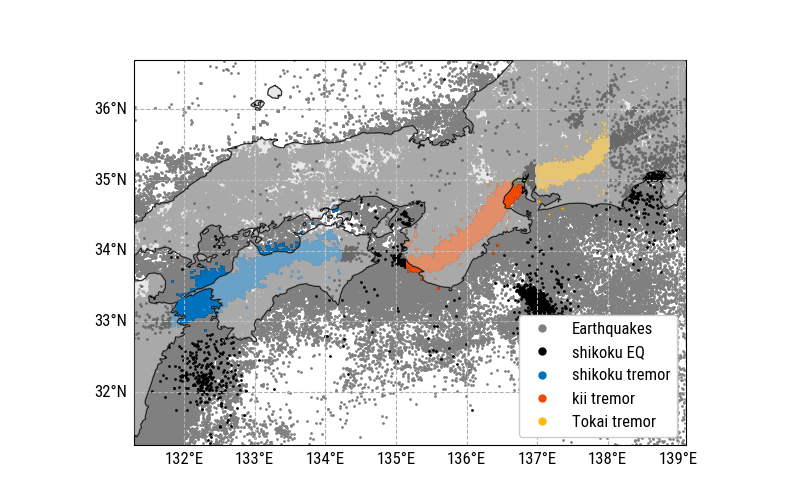

In [10]:
# Check distribution of events
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('.5', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')

# For seeing LFEs
ax.plot(wtd.lon, wtd.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
ax.plot(trm_shikoku.lon, trm_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku tremor')
ax.plot(trm_kii.lon, trm_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii tremor')
ax.plot(trm_tokai.lon, trm_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai tremor')

# # For seeing EQs
# ax.plot(eq_shikoku.lon, eq_shikoku.lat, 'o', color=to_rgba('C0', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
# ax.plot(eq_kii.lon, eq_kii.lat, 'o', color=to_rgba('C1', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii EQ')
# ax.plot(eq_tokai.lon, eq_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai EQ')
# ax.plot(wtd.lon, wtd.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tremor')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

ax.legend(framealpha=1, loc='lower right', markerscale=5)

ax.set_extent([131.3, 139.1, 31.25, 36.7])

plt.show()

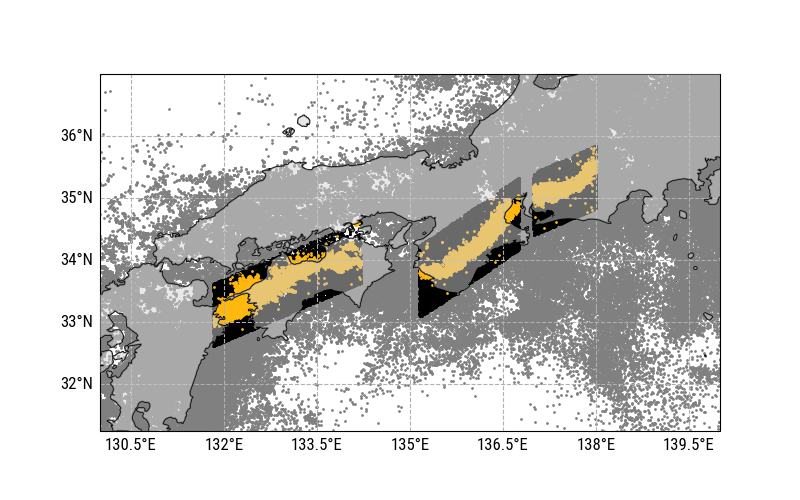

In [19]:
# Check distribution of events
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, zorder=10)
ax.add_feature(cfeature.LAND, facecolor=to_rgba('lightgray', .5), zorder=10)

ax.plot(eq.lon, eq.lat, 'o', color=to_rgba('.5', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Earthquakes')
# For seeing EQs
ax.plot(eq_shikoku.lon, eq_shikoku.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='shikoku EQ')
ax.plot(eq_kii.lon, eq_kii.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='kii EQ')
ax.plot(eq_tokai.lon, eq_tokai.lat, 'o', color=to_rgba('k', 1.), markersize=1, transform=ccrs.PlateCarree(), label='Tokai EQ')

# For seeing LFEs
ax.plot(trm_shikoku.lon, trm_shikoku.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree())
ax.plot(trm_kii.lon, trm_kii.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree())
ax.plot(trm_tokai.lon, trm_tokai.lat, 'o', color=to_rgba('C2', 1.), markersize=1, transform=ccrs.PlateCarree())


# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()


ax.set_extent([130, 140, 31.25, 37])

plt.show()

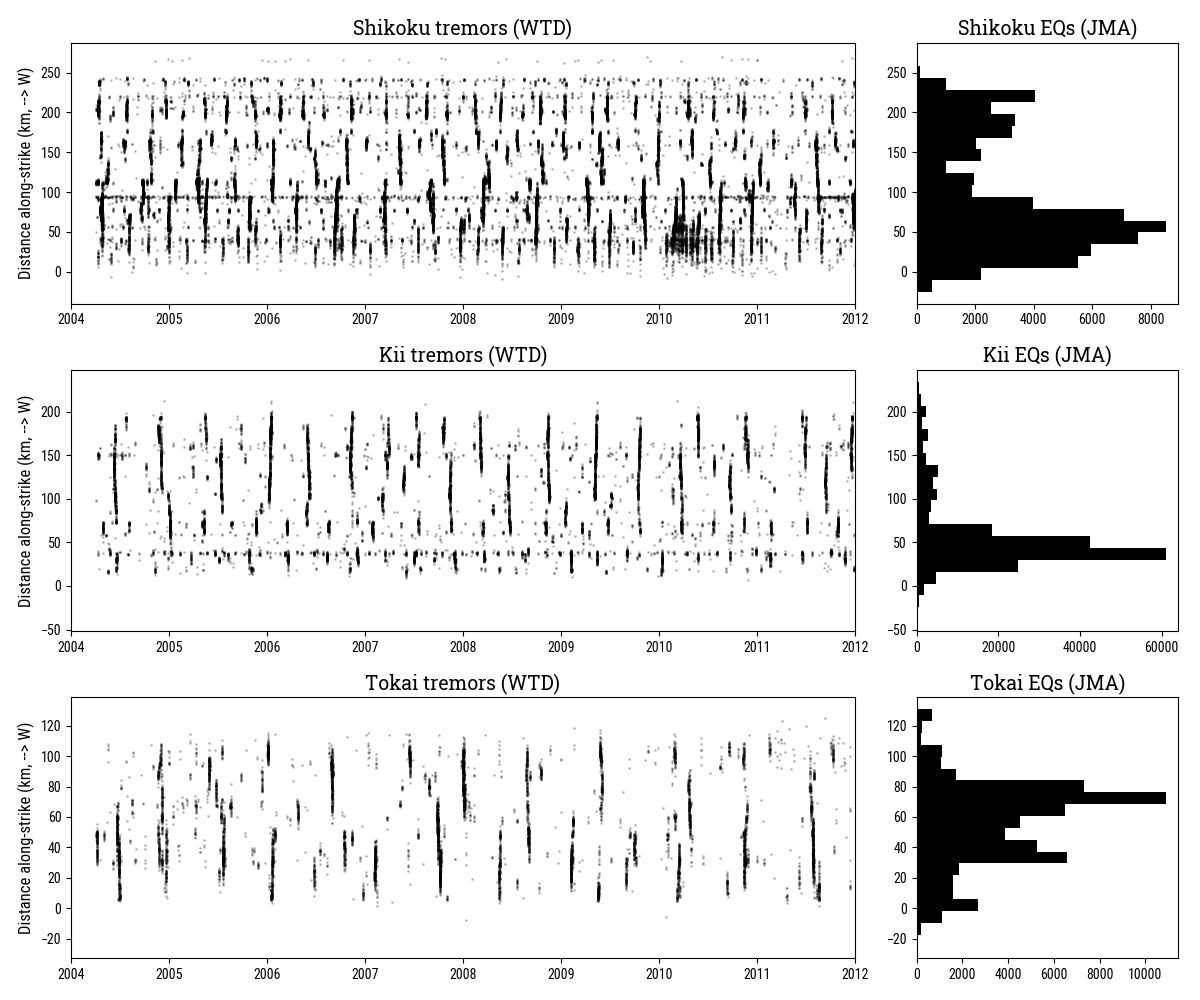

In [11]:
# Show activity
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

# shikoku
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('Shikoku tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_shikoku.date, trm_shikoku.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
ax.set_title('Shikoku EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_shikoku.xf, bins=20, orientation='horizontal', color='k')

# kii
ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('Kii tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_kii.date, trm_kii.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_title('Kii EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_kii.xf, bins=20, orientation='horizontal', color='k')

# Tokai
ax = fig.add_subplot(gs[2, 0])
ax.set_ylabel('Distance along-strike (km, --> W)')
ax.set_title('Tokai tremors (WTD)', fontsize=14, fontname='Roboto Slab')
ax.plot(trm_tokai.date, trm_tokai.xf, 'o', color=to_rgba('k', .2), markersize=1)
ax.set_xlim(np.datetime64('2004-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[2, 1], sharey=ax)
ax.set_title('Tokai EQs (JMA)', fontsize=14, fontname='Roboto Slab')
ax.hist(eq_tokai.xf, bins=20, orientation='horizontal', color='k')

plt.tight_layout()
plt.show()

# Measure correlation distances

## Shikoku

In [12]:
# # Check how one bin correlates with others in space (good way to find min velocity of clusters to consider)
# bins = np.arange(100, 200, 5)
# delta = 1.  # in days, the binning to compute event count in time
# v_min = 3.5  # km/day, slowest I could find is ~4 km/day

# tremor_in_bin0 = trm_shikoku.xf.between(bins[0], bins[1])
# count_bin0 = np.histogram(trm_shikoku[tremor_in_bin0].day.values, bins=np.arange(0, trm_shikoku.day.max()+delta, delta))[0]

# fig, axes = plt.subplots(len(bins), 1, figsize=(12, 12), sharex=True)
# for ax in axes:
#     ax.set_xlim(-300, 300)
#     ax.set_ylim(0, .4)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# for ii, xmin in enumerate(bins):
#     xmax = xmin + 10
#     tremor_in_bin = trm_shikoku.xf.between(xmin, xmax)
#     count_bin = np.histogram(trm_shikoku[tremor_in_bin].day.values, bins=np.arange(0, trm_shikoku.day.max()+delta, delta))[0]

#     cc, lag = cross_corr(count_bin0, count_bin, delta, norm=True, no_bias=True)
#     cc = (cc + cc[::-1]) / 2

#     ax = axes[ii]
#     ax.plot(lag, cc)
#     ax.axvspan((bins[0] - (xmin + 5))/v_min, (xmin + 5 - bins[0])/v_min, color='r', alpha=.1)

In [13]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 0
xmax_bin = 250
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = False  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [14]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm_shikoku.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    tremor_in_bin = trm_shikoku.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm_shikoku[tremor_in_bin].day.values, bins=count_time, weights=trm_shikoku[tremor_in_bin].dur.values)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

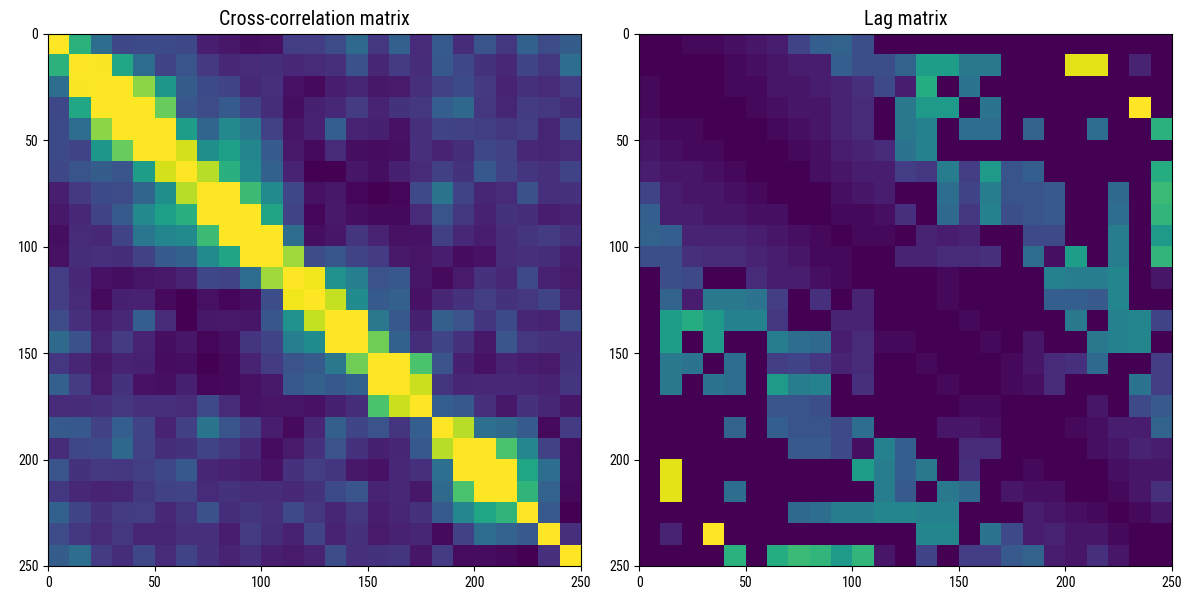

In [15]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

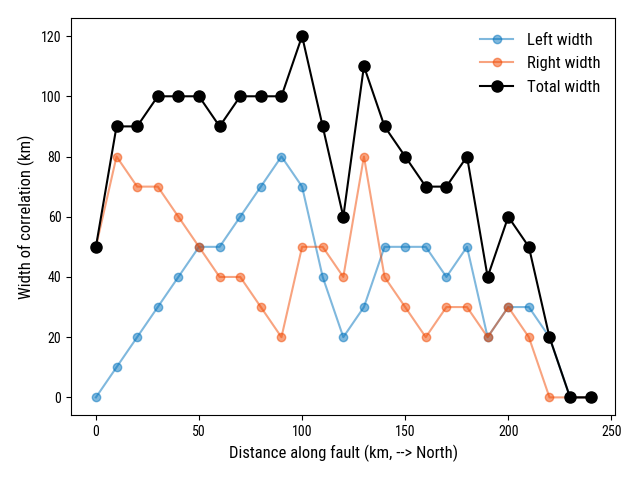

In [81]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, 'o-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, 'o-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], (np.array(left_width) + np.array(right_width)), 'ko-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

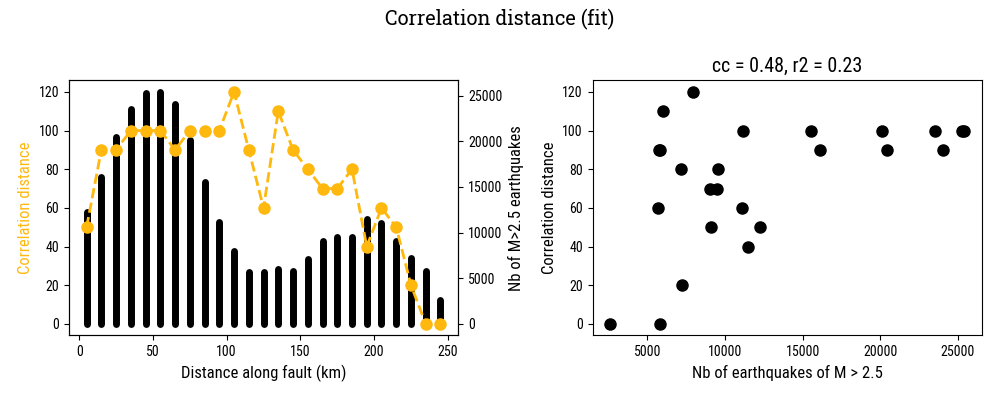

In [82]:
# So... do they correlate?
corr_dist = np.array(left_width) + np.array(right_width)
n_eq_bin = np.zeros_like(x_bin_edges[:-1])
dx_eq = 20
for ii in range(len(x_bin_edges)-1):
    n_eq_bin[ii] = len(eq_shikoku[(eq_shikoku.xf >= x_bin_edges[ii]-dx_eq) & (eq_shikoku.xf <= x_bin_edges[ii+1]+dx_eq)])

x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
corr_dist = corr_dist[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
n_eq_bin = n_eq_bin[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
x_bin_centers = x_bin_centers[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]

# Plot
mag_min = 2.5
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Correlation distance (fit)', fontname='Roboto Slab')

ax = axes[0]
ax.plot(x_bin_centers, corr_dist, 'o--', c='C2', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='C2')
ax.set_xlabel('Distance along fault (km)')

ax_eq = ax.twinx()
X, Y = [], []
for x,y in zip(x_bin_centers, n_eq_bin):
    X.extend([x, x, None]), Y.extend([0, y, None])
ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

ax.set_zorder(ax_eq.get_zorder()+1)
ax.patch.set_visible(False)

ax = axes[1]
ax.plot(n_eq_bin, corr_dist, 'o', c='k', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='k')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
cc = np.corrcoef(n_eq_bin, corr_dist)[0, 1]
r2 = 1 - np.sum((corr_dist - np.polyval(np.polyfit(n_eq_bin, corr_dist, 1), n_eq_bin))**2) / np.sum((corr_dist - np.mean(corr_dist))**2)
ax.set_title('cc = {:.2f}, r2 = {:.2f}'.format(cc, r2))

plt.tight_layout()
plt.show()

## Kii

In [87]:
# # Check how one bin correlates with others in space (good way to find min velocity of clusters to consider)
# bins = np.arange(100, 200, 5)
# delta = 1.  # in days, the binning to compute event count in time
# v_min = 3.5  # km/day, slowest I could find is ~4 km/day

# tremor_in_bin0 = trm_kii.xf.between(bins[0], bins[1])
# count_bin0 = np.histogram(trm_kii[tremor_in_bin0].day.values, bins=np.arange(0, trm_kii.day.max()+delta, delta))[0]

# fig, axes = plt.subplots(len(bins), 1, figsize=(12, 12), sharex=True)
# for ax in axes:
#     ax.set_xlim(-300, 300)
#     ax.set_ylim(0, .4)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# for ii, xmin in enumerate(bins):
#     xmax = xmin + 10
#     tremor_in_bin = trm_kii.xf.between(xmin, xmax)
#     count_bin = np.histogram(trm_kii[tremor_in_bin].day.values, bins=np.arange(0, trm_kii.day.max()+delta, delta))[0]

#     cc, lag = cross_corr(count_bin0, count_bin, delta, norm=True, no_bias=True)
#     cc = (cc + cc[::-1]) / 2

#     ax = axes[ii]
#     ax.plot(lag, cc)
#     ax.axvspan((bins[0] - (xmin + 5))/v_min, (xmin + 5 - bins[0])/v_min, color='r', alpha=.1)

In [88]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 0
xmax_bin = 200
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = False  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [89]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm_kii.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    tremor_in_bin = trm_kii.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm_kii[tremor_in_bin].day.values, bins=count_time, weights=trm_kii[tremor_in_bin].dur.values)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

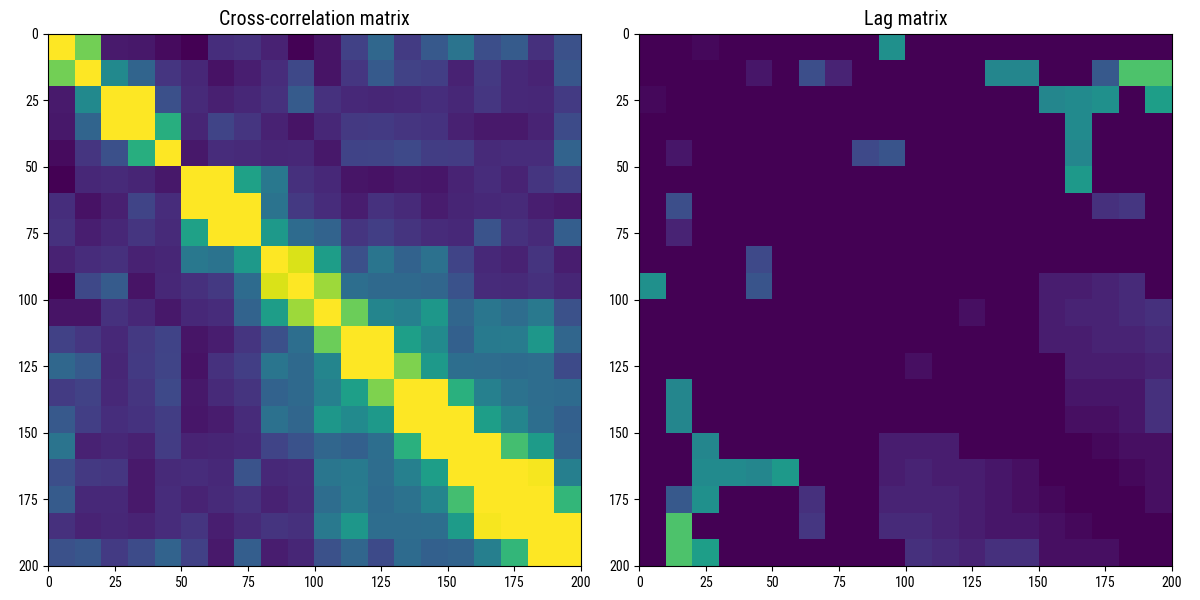

In [90]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

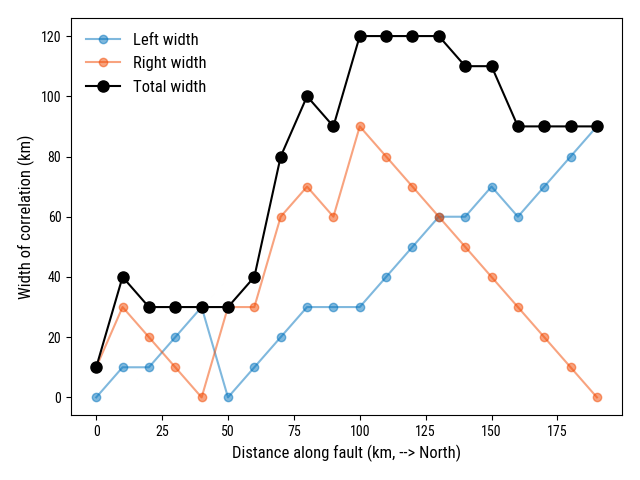

In [91]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, 'o-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, 'o-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], (np.array(left_width) + np.array(right_width)), 'ko-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

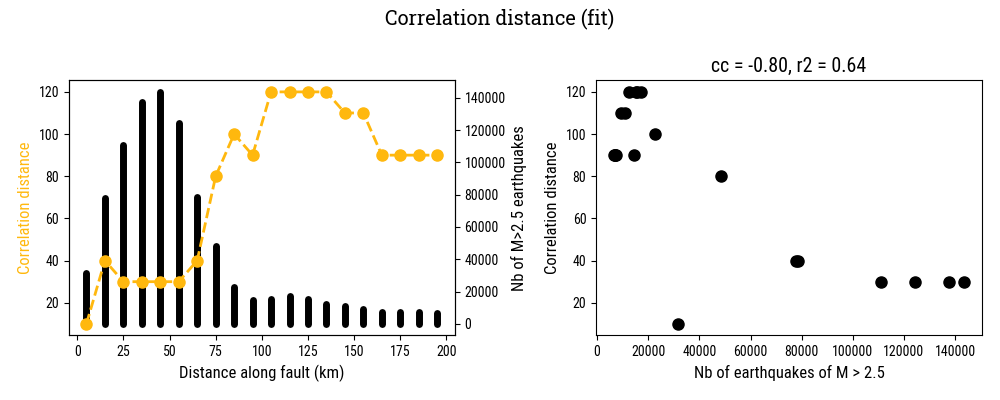

In [92]:
# So... do they correlate?
corr_dist = np.array(left_width) + np.array(right_width)
n_eq_bin = np.zeros_like(x_bin_edges[:-1])
dx_eq = 20
for ii in range(len(x_bin_edges)-1):
    n_eq_bin[ii] = len(eq_kii[(eq_kii.xf >= x_bin_edges[ii]-dx_eq) & (eq_kii.xf <= x_bin_edges[ii+1]+dx_eq)])

x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
corr_dist = corr_dist[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
n_eq_bin = n_eq_bin[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
x_bin_centers = x_bin_centers[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]

# Plot
mag_min = 2.5
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Correlation distance (fit)', fontname='Roboto Slab')

ax = axes[0]
ax.plot(x_bin_centers, corr_dist, 'o--', c='C2', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='C2')
ax.set_xlabel('Distance along fault (km)')

ax_eq = ax.twinx()
X, Y = [], []
for x,y in zip(x_bin_centers, n_eq_bin):
    X.extend([x, x, None]), Y.extend([0, y, None])
ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

ax.set_zorder(ax_eq.get_zorder()+1)
ax.patch.set_visible(False)

ax = axes[1]
ax.plot(n_eq_bin, corr_dist, 'o', c='k', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='k')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
cc = np.corrcoef(n_eq_bin, corr_dist)[0, 1]
r2 = 1 - np.sum((corr_dist - np.polyval(np.polyfit(n_eq_bin, corr_dist, 1), n_eq_bin))**2) / np.sum((corr_dist - np.mean(corr_dist))**2)
ax.set_title('cc = {:.2f}, r2 = {:.2f}'.format(cc, r2))

plt.tight_layout()
plt.show()

## Tokai

In [93]:
# # Check how one bin correlates with others in space (good way to find min velocity of clusters to consider)
# bins = np.arange(50, 120, 5)
# delta = 1.  # in days, the binning to compute event count in time
# v_min = 3.5  # km/day, slowest I could find is ~4 km/day

# tremor_in_bin0 = trm_tokai.xf.between(bins[0], bins[1])
# count_bin0 = np.histogram(trm_tokai[tremor_in_bin0].day.values, bins=np.arange(0, trm_tokai.day.max()+delta, delta))[0]

# fig, axes = plt.subplots(len(bins), 1, figsize=(12, 12), sharex=True)
# for ax in axes:
#     ax.set_xlim(-300, 300)
#     ax.set_ylim(0, .4)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# for ii, xmin in enumerate(bins):
#     xmax = xmin + 10
#     tremor_in_bin = trm_tokai.xf.between(xmin, xmax)
#     count_bin = np.histogram(trm_tokai[tremor_in_bin].day.values, bins=np.arange(0, trm_tokai.day.max()+delta, delta))[0]

#     cc, lag = cross_corr(count_bin0, count_bin, delta, norm=True, no_bias=True)
#     cc = (cc + cc[::-1]) / 2

#     ax = axes[ii]
#     ax.plot(lag, cc)
#     ax.axvspan((bins[0] - (xmin + 5))/v_min, (xmin + 5 - bins[0])/v_min, color='r', alpha=.1)

In [94]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 5  # in km, width of bin
xmin_bin = 0
xmax_bin = 120
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = False  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [95]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm_tokai.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    tremor_in_bin = trm_tokai.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm_tokai[tremor_in_bin].day.values, bins=count_time, weights=trm_tokai[tremor_in_bin].dur.values)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

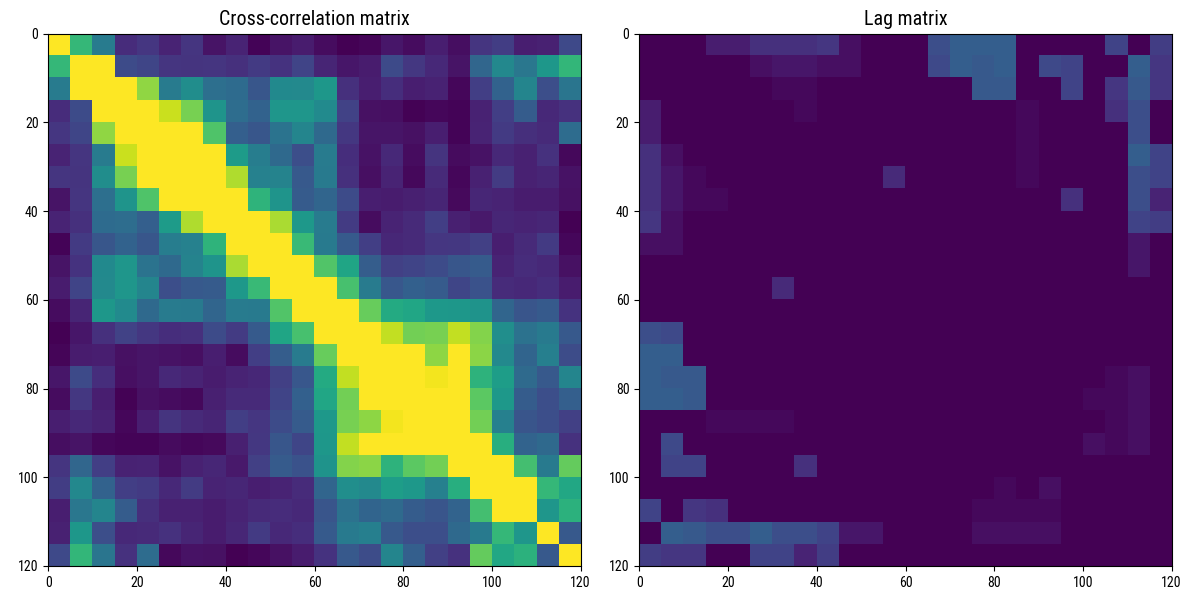

In [96]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

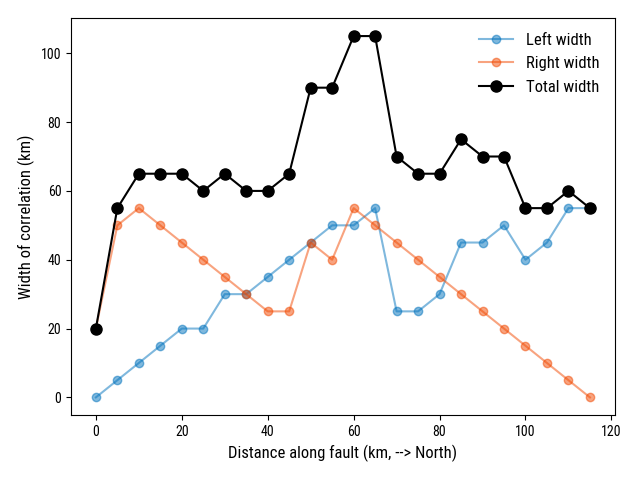

In [97]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, 'o-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, 'o-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], (np.array(left_width) + np.array(right_width)), 'ko-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

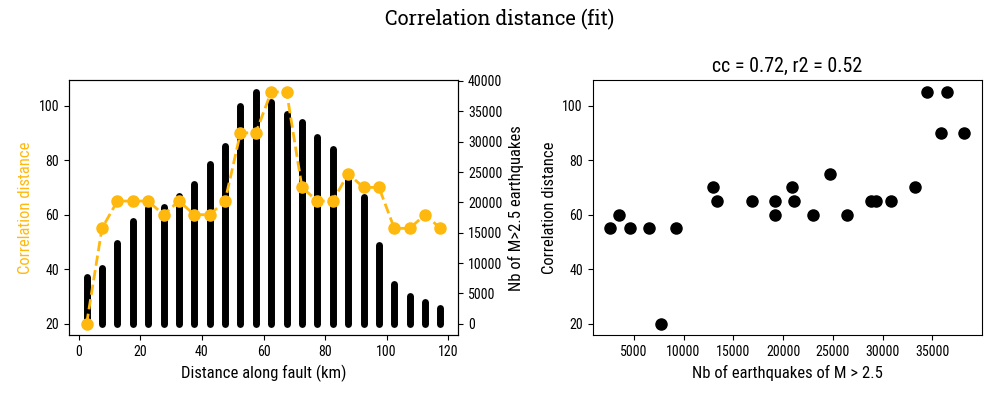

In [98]:
# So... do they correlate?
corr_dist = np.array(left_width) + np.array(right_width)
n_eq_bin = np.zeros_like(x_bin_edges[:-1])
dx_eq = 20
for ii in range(len(x_bin_edges)-1):
    n_eq_bin[ii] = len(eq_tokai[(eq_tokai.xf >= x_bin_edges[ii]-dx_eq) & (eq_tokai.xf <= x_bin_edges[ii+1]+dx_eq)])

x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
corr_dist = corr_dist[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
n_eq_bin = n_eq_bin[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]
x_bin_centers = x_bin_centers[(x_bin_centers >= xmin_bin) & (x_bin_centers <= xmax_bin)]

# Plot
mag_min = 2.5
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Correlation distance (fit)', fontname='Roboto Slab')

ax = axes[0]
ax.plot(x_bin_centers, corr_dist, 'o--', c='C2', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='C2')
ax.set_xlabel('Distance along fault (km)')

ax_eq = ax.twinx()
X, Y = [], []
for x,y in zip(x_bin_centers, n_eq_bin):
    X.extend([x, x, None]), Y.extend([0, y, None])
ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

ax.set_zorder(ax_eq.get_zorder()+1)
ax.patch.set_visible(False)

ax = axes[1]
ax.plot(n_eq_bin, corr_dist, 'o', c='k', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='k')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
cc = np.corrcoef(n_eq_bin, corr_dist)[0, 1]
r2 = 1 - np.sum((corr_dist - np.polyval(np.polyfit(n_eq_bin, corr_dist, 1), n_eq_bin))**2) / np.sum((corr_dist - np.mean(corr_dist))**2)
ax.set_title('cc = {:.2f}, r2 = {:.2f}'.format(cc, r2))

plt.tight_layout()
plt.show()